# Programmentwurf
In dieser Aufgabe wollen wir Bilder in 6 verschiedene Klassen klassifizieren: "Häuser, Wald, Gletscher, Berge, Wasser, Straße".

## Laden einiger wichtiger Bibliotheken

In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plot
from random import randint
import random

## Laden weiterer Bibliotheken
Soweit benötigt können natürlich weiter Python-Bibliotheken geladen werden. Bitte diese Bibliotheken im unteren Codeblock einfügen.

In [2]:
# Code
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt             
from sklearn.naive_bayes import MultinomialNB
from sklearn import  metrics
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import seaborn as sn; sn.set(font_scale=1.4)
from numpy.random import seed
from tensorflow import random

## Dictionary/Map von Klassenname zu Index
Wir bauen ein Mapping zwischen Klassenlabel und Klassenindex

In [3]:
labelMap = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}
keyMap = {v: k for k, v in labelMap.items()}
class_names = labelMap.keys()

print(labelMap)
print(keyMap)
print(class_names)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
dict_keys(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])


Methode um Bilder aus einem Verzeichnis zu laden

In [4]:
def get_images(directory):
    Images = []
    Labels = []  
    label = 0
    
    for dirName in os.listdir(directory):
        #print(dirName)
        label = labelMap[dirName]
        
        for image_file in os.listdir(directory+dirName): 
            image = cv2.imread(directory+dirName+r'/'+image_file) 
            im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if image.shape == (150, 150, 3):
                Images.append(im_rgb)
                Labels.append(label)
    
    return Images,Labels

Alternativmethode um die Dateien aus einem ZIP-Archiv zu extrahieren.

In [5]:
import zipfile
def get_imagesZip(directory):

    with zipfile.ZipFile(directory) as archive:
        dirName = None

        Images = []
        Labels = []  
        label = 0

        for file in archive.namelist():
            file_info = archive.getinfo(file)

            if file_info.is_dir():
                dirName = file_info.filename
                dirName = dirName[0:dirName.rfind('/')]
                dirName = dirName[dirName.rfind('/')+1:]
                label = labelMap[dirName]
            else:
                imgfile = archive.read(file)

                nparr = np.fromstring(imgfile, np.uint8)
                image = cv2.imdecode(nparr, cv2.IMREAD_COLOR) 
                im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                if image.shape == (150, 150, 3):
                    Images.append(im_rgb)
                    Labels.append(label)
        return Images,Labels

## Laden der Trainingsdaten
Wir laden die Trainingsdaten aus den angegebenen Zip-Dateien

In [6]:
#x_train, Y_train = get_images('train/') #Alternativ
x_train, Y_train = get_imagesZip('train.zip')

C:\Users\Leon\AppData\Local\Temp\ipykernel_25508\1017228595.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(imgfile, np.uint8)


## Konvertiere Bilder in Numpy-Arrays

In [7]:
x_train = np.array(x_train) 
Y_train = np.array(Y_train)

In [8]:
print("Shape of Images:",x_train.shape)
print("Shape of Labels:",Y_train.shape)

Shape of Images: (13986, 150, 150, 3)
Shape of Labels: (13986,)


## Zählen der einzelnen Bildklassen
Für einen ersten Eindruck wollen wir wissen, ob die einzelnen Klassen in etwa gleichverteilt sind.

In [9]:
unique_elements, counts_elements = np.unique(Y_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1    2    3    4    5]
 [2190 2263 2387 2495 2270 2381]]


## Plotten der Daten

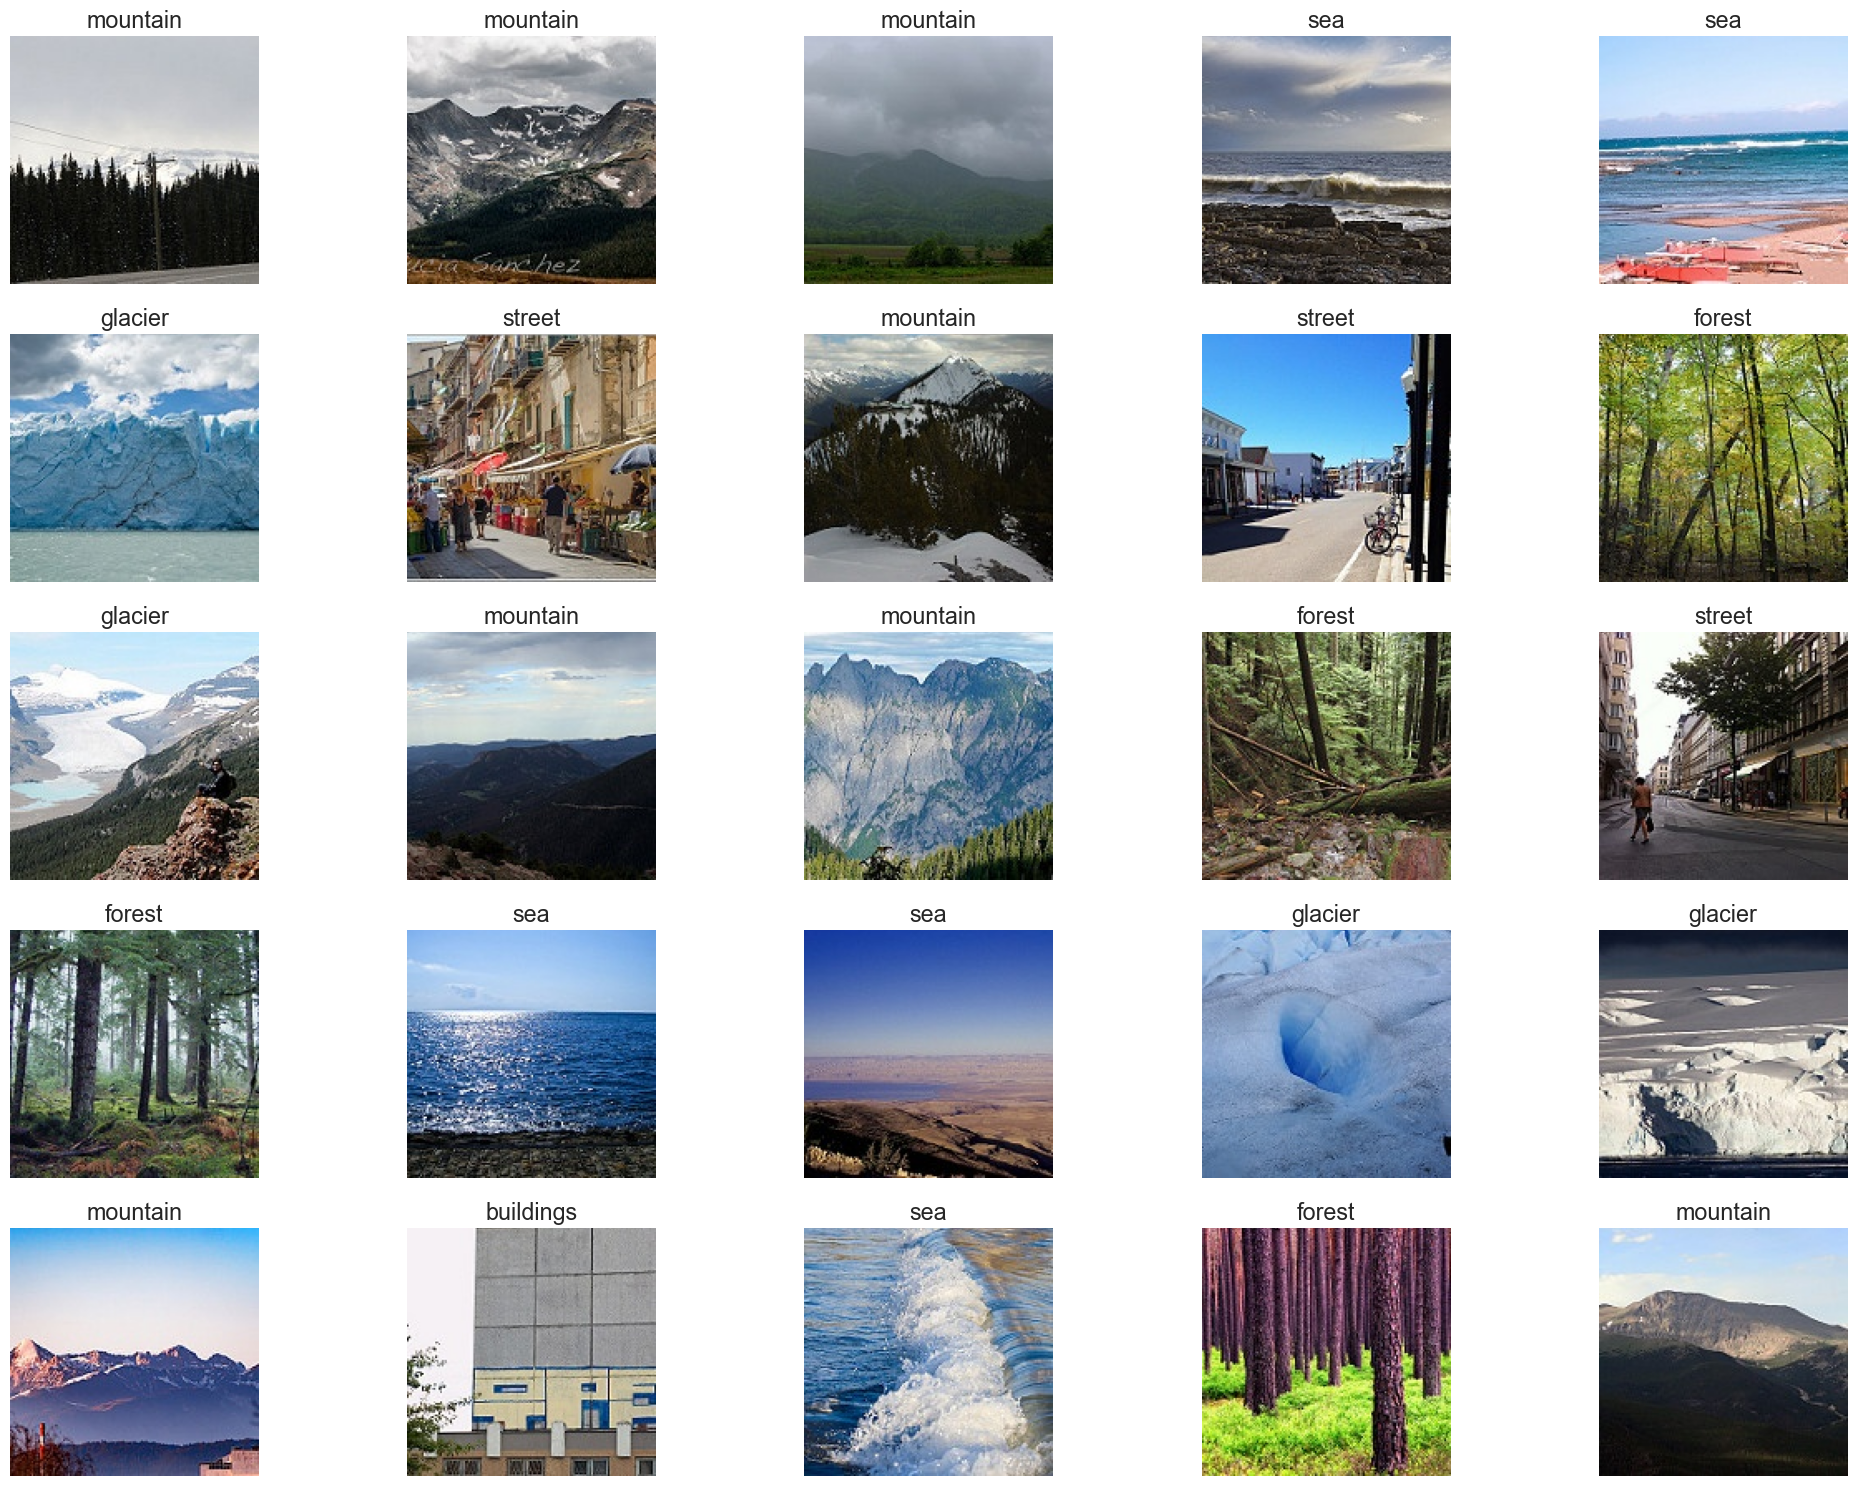

In [11]:
random.set_seed(1202)
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(x_train))
        ax[i,j].imshow(x_train[rnd_number])
        ax[i,j].set_title(keyMap[Y_train[rnd_number]])
        ax[i,j].axis('off')

## 1.)  Erstellen Sie ein Evaluationsszenario  (5 Punkte)

### 1.1) Erstellen Sie einen stratifizierten Train/Dev-Split (80%-Train / 20%-Dev). 

In [12]:
# Code
x_train, x_dev, Y_train, Y_dev = train_test_split(x_train, Y_train, test_size=0.2, random_state=0)

### 1.2) Veranschaulichen Sie, dass die Splits wirklich stratifiziert sind


Stratifying our sample ensures that the class proportion of the testing data matches the class proportion of the training data. Luckily, we can see that the inital split of the classes in the train/test folder already fullfills the criteria of a stratified sample, which is why the datasets won't be merged and afterwards splitted again in this project.

In [12]:
n_train = Y_train.shape[0]
n_test = Y_dev.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of dev examples: {}".format(n_test))

Number of training examples: 11188
Number of dev examples: 2798


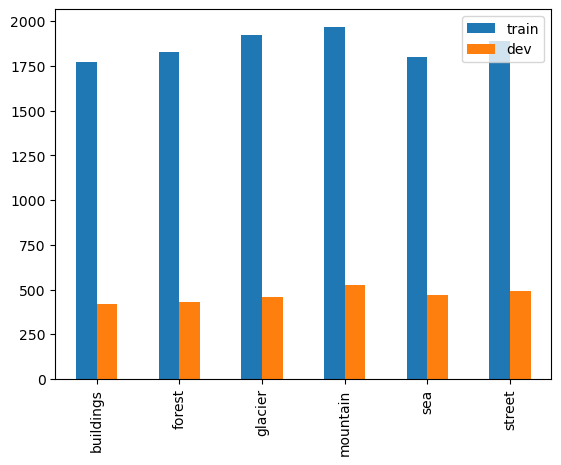

In [13]:
_, train_counts = np.unique(Y_train, return_counts=True)
_, dev_counts = np.unique(Y_dev, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'dev': dev_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

### 1.3) Laden Sie die Testdaten (test.zip) und veranschaulichen Sie deren Verteilung

In [14]:
# Code
x_test, Y_test = get_imagesZip('test.zip')

C:\Users\Leon\AppData\Local\Temp\ipykernel_25896\1017228595.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(imgfile, np.uint8)


In [15]:
x_test = np.array(x_test) 
Y_test = np.array(Y_test)

In [16]:
print("Shape of Images:",x_test.shape)
print("Shape of Labels:",Y_test.shape)

Shape of Images: (2993, 150, 150, 3)
Shape of Labels: (2993,)


In [17]:
_, test_counts = np.unique(Y_test, return_counts=True)

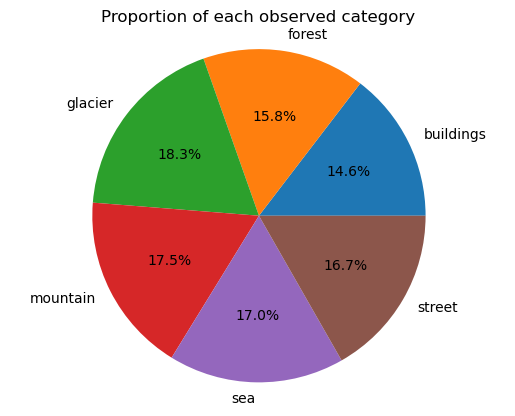

In [18]:
plt.pie(test_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

##  2.) Trainieren Sie eine Baseline  (10 Punkte)

### 2.1) Trainieren Sie (auf den Trainingsdaten) einen Naive Bayes-Klassifikator, welcher alle 6 Bildklassen erkennt. 

In [19]:
x_test = x_test / 255.0 
x_train = x_train / 255.0
x_dev = x_dev/255

In [20]:
# Looking at the shape of the array we note that we deal with images that have a width and height of 150 pixels each,
# as well as an additional dimension for the RGB values.
x_train.shape

(11188, 150, 150, 3)

In [21]:
# As we first want to use NaiveBayes as a baseline model, we have to convert the color image 3D array to a grayscale 2D array,
# from which we then can build a single vector by multiplying width and height. To do this, we build the average
# of the RGB-values in the third dimension.

#Converting the testing data
x_test_RGB = np.mean(x_test, axis=3)

#Converting the training data
x_train_RGB = np.mean(x_train, axis=3)

#Converting the dev data
x_dev_RGB = np.mean(x_dev, axis=3)

In [22]:
x_train_RGB.shape

(11188, 150, 150)

In [23]:
#Looking at the first image, we can validate that the mean of the three RGB values has been successfully calculated
x_train_RGB[0]

array([[0.62222222, 0.62614379, 0.62614379, ..., 0.80653595, 0.80653595,
        0.80653595],
       [0.62222222, 0.62614379, 0.62614379, ..., 0.81045752, 0.81045752,
        0.81045752],
       [0.62614379, 0.62614379, 0.62614379, ..., 0.81045752, 0.81437908,
        0.81437908],
       ...,
       [0.76078431, 0.97385621, 0.67320261, ..., 0.10849673, 0.05228758,
        0.09150327],
       [0.85490196, 0.98300654, 0.88366013, ..., 0.12287582, 0.07712418,
        0.13986928],
       [0.44052288, 0.20915033, 0.25751634, ..., 0.13071895, 0.07581699,
        0.12287582]])

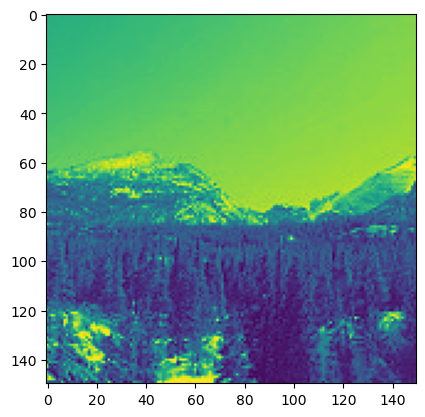

In [24]:
plt.imshow(x_train_RGB[0])

In [25]:
#Reshaping the data to a single input vector
x_train_RGB_NB = x_train_RGB.reshape((x_train_RGB.shape[0], 150 * 150))
x_dev_RGB_NB = x_dev_RGB.reshape((x_dev_RGB.shape[0], 150 * 150))
x_test_RGB_NB = x_test_RGB.reshape((x_test_RGB.shape[0], 150 * 150))

In [26]:
# Choosing Multonominal Naive Bayes, as we try to predict several classes
classifier = MultinomialNB()

#Training the model
classifier.fit(x_train_RGB_NB, Y_train)

MultinomialNB()

### 2.2) Evaluieren Sie diesen Klassifikator auf dem Test-Set (Accuracy)


In [27]:
predicted = classifier.predict(x_test_RGB_NB)

In [31]:
predicted

array([0, 2, 3, ..., 4, 1, 2])

In [32]:
predicted.shape

(2993,)

In [34]:
accuracy_nb = metrics.accuracy_score(Y_test,predicted)
%store accuracy_nb
print("Accuracy of ", accuracy_nb)

Stored 'accuracy_nb' (float64)
Accuracy of  0.3317741396592048


By choosing Naive Bayes as a baseline model, we obtain an accuracy of 33%.

## 3.)  Trainieren Sie ein Neuronales Netz zur Bilderkennung (20 Punke)

### 3.1) Entwickeln Sie ein mehrschichtiges CNN-Model mit Dropout


In [41]:
model = Sequential()

#Defining the input shape of the first layer of the neuronal network
model.add(Conv2D(10, kernel_size=(3,3), activation="sigmoid", input_shape=(150,150,3)))
model.add(Flatten())
model.add(Dense(100,activation="sigmoid"))
#Adding a dropout with 0.25 which will randomly delete some paths during the training
model.add(Dropout(0.25))
model.add(Dense(6,activation="softmax"))

model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    x_train,
    Y_train,
    epochs=10,
    batch_size=1000,
    validation_data=(x_dev, Y_dev))

Epoch 1/10
12/12 [==============================] - 50s 3s/step - loss: 2.1996 - accuracy: 0.1664 - val_loss: 1.8307 - val_accuracy: 0.1751
Epoch 2/10
12/12 [==============================] - 36s 3s/step - loss: 1.8977 - accuracy: 0.1639 - val_loss: 1.7922 - val_accuracy: 0.2320
Epoch 3/10
12/12 [==============================] - 36s 3s/step - loss: 1.8680 - accuracy: 0.1692 - val_loss: 1.7964 - val_accuracy: 0.1751
Epoch 4/10
12/12 [==============================] - 34s 3s/step - loss: 1.8526 - accuracy: 0.1758 - val_loss: 1.8163 - val_accuracy: 0.1497
Epoch 5/10
12/12 [==============================] - 34s 3s/step - loss: 1.8457 - accuracy: 0.1736 - val_loss: 1.7860 - val_accuracy: 0.2538
Epoch 6/10
12/12 [==============================] - 34s 3s/step - loss: 1.8274 - accuracy: 0.1884 - val_loss: 1.8036 - val_accuracy: 0.1808
Epoch 7/10
12/12 [==============================] - 34s 3s/step - loss: 1.8187 - accuracy: 0.1890 - val_loss: 1.7714 - val_accuracy: 0.1751
Epoch 8/10
12/12 [==

### 3.2) Entwickeln Sie ein beliebiges neuronales Modell (z.B. Residual-connections, mehr/weniger Schichten als 3.1 etc)


In comparison to the first model, the following changes were made to improve the performance:

#### Model architecture:
**Kernel size/filters**: Was increased from 10 to 32, which allows the model to detect more features(edges). <br/>
**Activation function**: Was changed from Sigmoid to ReLu, to avoid the vanishing gradient problem, which no longer allows our model to learn. <br/>
**Layers**: In addition to the Convolutional, Dense and Flatten Layers, Max-Pooling was introduced. The 2,2 filter takes the maximum value of the matrix and helps our model to generalize better.

#### Model training:
**Epochs and batch size**: While epochs were increased, batch size was decreased, so that model2 trains on a smaller number of images at once, allowing for less drastic changes every batch. <br/>
**Optimizer:** Whereas Stochastic Gradient Descent (SGD) was used in the first model, Adam was chossen in the second model. Adam has several advantages over SGD, e.g. the concept of momentum wich makes our model less prone to "noisy examples", as well as the adaption of learning rates for different predictors.

In [42]:
model2 = Sequential()

model2.add(Conv2D(32, (3,3), activation="relu", input_shape=(150,150,3)))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(32, (3,3), activation="relu"))
model2.add(MaxPooling2D(2,2))
model2.add(Flatten())
model2.add(Dense(128,activation="relu"))
model2.add(Dense(6,activation="softmax"))

model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history2 = model2.fit(
    x_train,
    Y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_dev, Y_dev))

Epoch 1/10
88/88 [==============================] - 116s 1s/step - loss: 1.3443 - accuracy: 0.5318 - val_loss: 0.9414 - val_accuracy: 0.6272
Epoch 2/10
88/88 [==============================] - 111s 1s/step - loss: 0.7891 - accuracy: 0.7129 - val_loss: 0.8018 - val_accuracy: 0.6994
Epoch 3/10
88/88 [==============================] - 111s 1s/step - loss: 0.6207 - accuracy: 0.7757 - val_loss: 0.7174 - val_accuracy: 0.7423
Epoch 4/10
88/88 [==============================] - 105s 1s/step - loss: 0.4830 - accuracy: 0.8288 - val_loss: 0.6900 - val_accuracy: 0.7659
Epoch 5/10
88/88 [==============================] - 108s 1s/step - loss: 0.3367 - accuracy: 0.8850 - val_loss: 0.7284 - val_accuracy: 0.7645
Epoch 6/10
88/88 [==============================] - 123s 1s/step - loss: 0.2414 - accuracy: 0.9242 - val_loss: 0.7830 - val_accuracy: 0.7727
Epoch 7/10
88/88 [==============================] - 113s 1s/step - loss: 0.1713 - accuracy: 0.9459 - val_loss: 0.8887 - val_accuracy: 0.7445
Epoch 8/10
88

### 3.3) Visualisieren Sie die Architekturen der beiden Modelle


In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 10)      280       
                                                                 
 flatten_2 (Flatten)         (None, 219040)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               21904100  
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 606       
                                                                 
Total params: 21,904,986
Trainable params: 21,904,986
Non-trainable params: 0
_________________________________________________________________


In [44]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 41472)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

### 3.4) Plotten Sie für beide Modelle den Loss und die Accuracy über 10 Epochen
Beobachten Sie Anzeichen von Overfitting? Würden Sie das Modell für weitere Epochen trainieren wollen? Begründen Sie Ihre Antwort


### Evaluation of Loss and Accuracy: Model1

In the following we plot the metrics of accuraracy and loss on the training data as well as validation accuracy and validation loss on the testing data.
The former two thereby indicate how well the model is progressing in terms of it's training, while the latter serve as a measure of quality of the model, as they allow us to see how well it's making predictions based on data it hasn't seen before.
Hence, we can use the measures to prevent *overfitting*. Overfitting is when the model fits the training data too closely, and the loss keeps decreasing while the val_loss is stale, or increases.

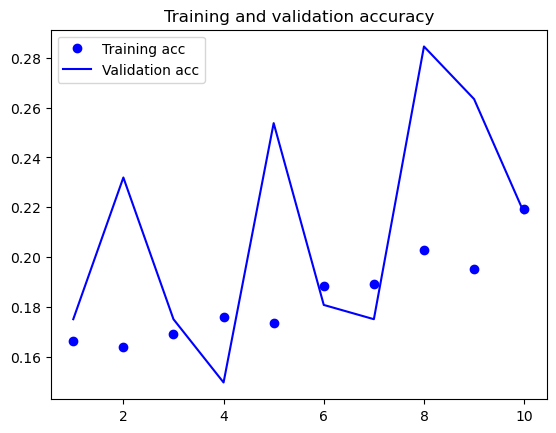

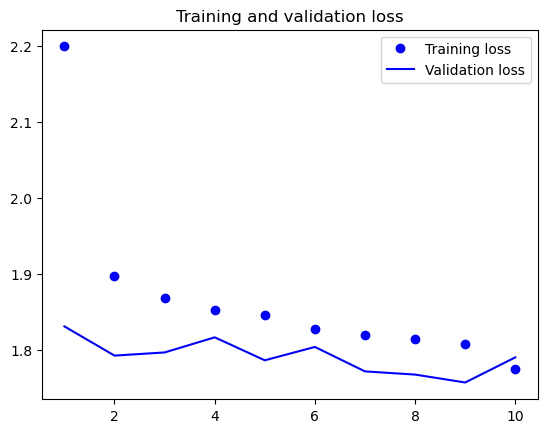

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Model 1: Due to the low overall accuracy of the model of about only 21% on the training data as well as on the testing data, it's hard to tell whether the model overfits the data. As validation accuracy is best after eight epochs and testing accuracy afterwards exceeds validation accuracy, I'd recommend to stop the training afterwards.

### Evaluation of Loss and Accuracy: Model2

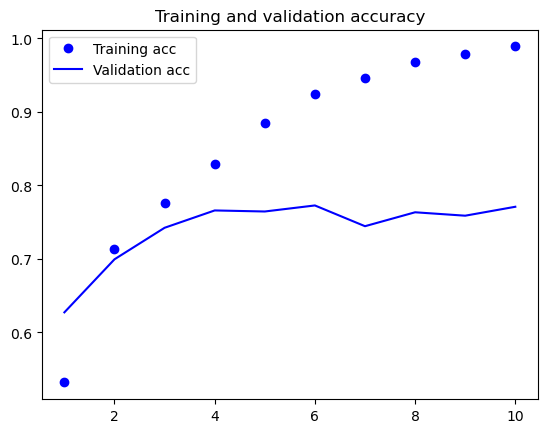

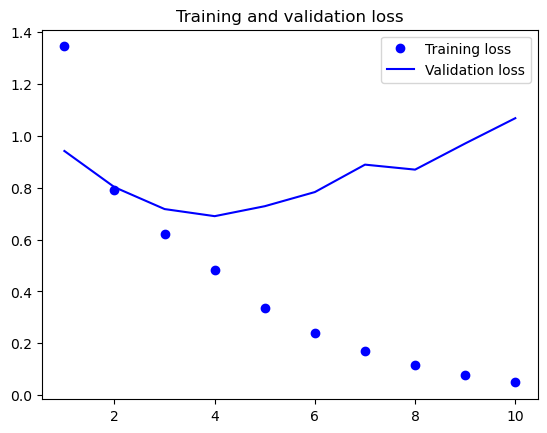

In [46]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Model 2: When going from epoch 3 to epoch 5 we can see that the testing accuracy is increasing, while val_accuracy is at first decreasing and then stable. This means that the model is fitting the training set better, but looses it's ability to predict on new data. Hence, we should stop the training after having finished the third epoch.

In [47]:
history_dict = history2.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## 4.) Evaluieren und interpretieren Sie das Netzwerk auf den Test-Daten (20)


### 4.1) Vergleichen Sie die Performanz beider neuronalen Modelle und die baseline. Welches Modell würden Sie produktiv einsetzen? Alle weiteren Analysen erfolgen auf dem, Ihrer Meinung nach, besseren (neuronalen) Modell


In [48]:
test_loss_model1 = model.evaluate(x_test, Y_test)

94/94 [==============================] - 4s 43ms/step - loss: 1.7933 - accuracy: 0.2212


In [49]:
test_loss_model2 = model2.evaluate(x_test, Y_test)

94/94 [==============================] - 8s 89ms/step - loss: 1.0856 - accuracy: 0.7541


In [50]:
acc_model = test_loss_model1[1]
acc_model2 = test_loss_model2[1]
%store -r accuracy_nb

print ("Accuracy of our baseline model (NaiveBayes): ", accuracy_nb) 
print ("Accuracy of model1 (aka the bad one): ", acc_model) 
print ("Accuracy of model2 (aka the good one): ", acc_model2) 

Accuracy of our baseline model (NaiveBayes):  0.3317741396592048
Accuracy of model1 (aka the bad one):  0.22118276357650757
Accuracy of model2 (aka the good one):  0.7540928721427917


As model2 outperforms the baseline model as well as the competing neuronal model to a large extend, model2 should be used in a productive environment. Also, further analysis will be carried out on this mode

### 4.2) Schätzen Sie die Genauigkeit/Accuracy Ihrer Methode für jede Klasse separat, sowie für alle Klasse


In [51]:
predictions = model2.predict(x_test)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

94/94 [==============================] - 6s 67ms/step


In [52]:
print(metrics.classification_report(Y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.74      0.67      0.70       437
           1       0.96      0.85      0.90       473
           2       0.79      0.65      0.71       549
           3       0.72      0.70      0.71       523
           4       0.66      0.82      0.73       510
           5       0.72      0.85      0.78       501

    accuracy                           0.75      2993
   macro avg       0.77      0.76      0.76      2993
weighted avg       0.76      0.75      0.75      2993



When predicting classes based on our testig data, we can see that our model has an average precison of 77%. Thereby the class 1 (forest) was predicted with the greatest precision (96%), while class 4 (sea) showed the least precison (66%).

### 4.3) Erzeugen Sie eine Confusion Matrix 


Text(0.5, 1.0, 'Confusion matrix')

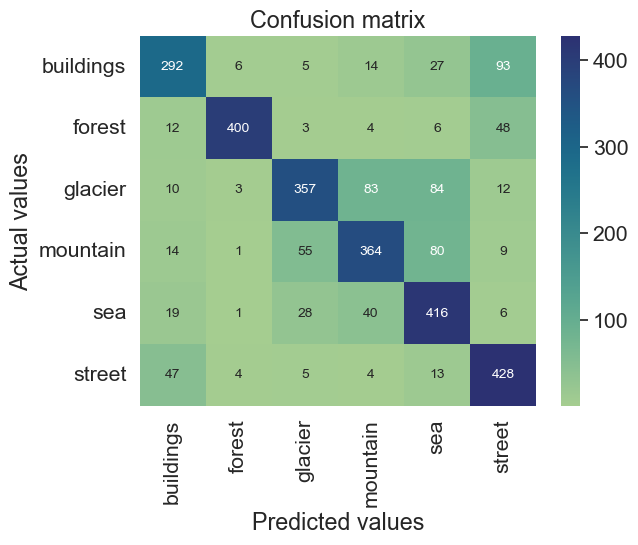

In [58]:
CM = confusion_matrix(Y_test, pred_labels)
ax = plt.axes()

sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           fmt="d",
           cmap = "crest",
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
ax.set_title('Confusion matrix')

### 4.4) Interpretation der Confusion-Matrix. Welche Klasse ist am schwersten zu klassifizieren und mit welchen Klassen wird sie oft „verwechselt“


The confusion matrix tells us that the model has a particular hard time predicting class 0, i.e. buildings, correct. Images of the respective class are thereby mainly confused with images that display a street. Intuitively, the confusion of street and buildings could be due to the fact that buildings are next to streets.
Also, images that display a galcier, mountain or sea are prone to confusion. Intuitively this could be due to the large share of white and blue areas in the images as well as the fact that glaciers are embedded in mountains.

## 5.) Geben Sie für ein ausgewähltes Testbild (example-150.png) die Klassenwahrscheinlichkeiten aus (5 Punkte)


### 5.1) Wenden Sie Ihr Modell auf das Testbild (example-150.png) an.
Plotten Sie das ausgewählte Bild und nennen Sie die 6 Wahrscheinlichkeiten der einzelnen Bildklassen


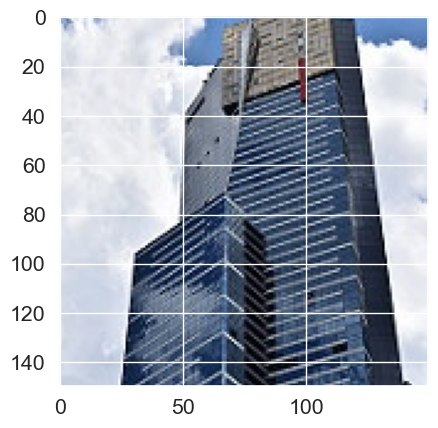

In [59]:
plt.imshow(x_test[0])
plt.show()

In [61]:
arr_predictions_ = predictions[0]
arr_predictions_perc = arr_predictions_*100
count = -1

print("We obtain the following probabilities for the respective classes of the chosen image:")

for i in arr_predictions_perc:
    count = count+1
    print("Class " + str(count) + ": " + format(i,'f') + " %")

We obtain the following probabilities for the respective classes of the chosen image:
Class 0: 92.551880 %
Class 1: 0.000005 %
Class 2: 0.642284 %
Class 3: 0.496518 %
Class 4: 6.308593 %
Class 5: 0.000715 %


## 6.) Trainieren Sie für jede der beiden neuronalen Architekturen mehrere Modelle (20 Punkte)



### 6.1) Definieren Sie (mindestens) 5 random seeds 


Note: Training epochs were reduced to four, compared to the model in 3.2 as no improvements in accuracy were obtained afterwards on testing data.

### 6.2) Trainieren Sie für jeden random seed die Modelle (3.1 und 3.2)


### Random seeds model1 (aka "the bad one")

In [66]:
results1 = []

# fit model1 to dataset and store results
def fit_model(count, x_train, Y_train, x_dev, Y_dev, x_test, Y_test):
    
    #set numpy seed
    seed(count)
    #set tensorflow seed
    random.set_seed(count)
    

    model = Sequential()

    #Defining the input shape of the first layer of the neuronal network
    model.add(Conv2D(10, kernel_size=(3,3), activation="sigmoid", input_shape=(150,150,3)))
    model.add(Flatten())
    model.add(Dense(100,activation="sigmoid"))
    #Adding a dropout with 0.25 which will randomly delete some paths during the training
    model.add(Dropout(0.25))
    model.add(Dense(6,activation="softmax"))

    model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # fit network
    history = model.fit(x_train, Y_train, epochs=4, batch_size=1000,validation_data=(x_dev, Y_dev))
    
    # evaluate model1 and store result
    results1.append(model.evaluate(x_test, Y_test))

In [67]:
# fit model1 five times
count = 0
repeats = 5
for _ in range(repeats):
    count = count + 1
    fit_model(count, x_train, Y_train, x_dev, Y_dev, x_test, Y_test)
    print("Training model1, seed " + str(count) + " commpleted.")

Epoch 1/4
12/12 [==============================] - 47s 3s/step - loss: 2.1218 - accuracy: 0.1668 - val_loss: 1.7927 - val_accuracy: 0.1544
Epoch 2/4
12/12 [==============================] - 35s 3s/step - loss: 1.8417 - accuracy: 0.1718 - val_loss: 1.7872 - val_accuracy: 0.1544
Epoch 3/4
12/12 [==============================] - 36s 3s/step - loss: 1.8231 - accuracy: 0.1943 - val_loss: 1.8205 - val_accuracy: 0.1576
Epoch 4/4
94/94 [==============================] - 5s 48ms/step - loss: 1.7698 - accuracy: 0.1674
Training model1, seed 1 commpleted.
Epoch 1/4
12/12 [==============================] - 42s 3s/step - loss: 2.0768 - accuracy: 0.1667 - val_loss: 1.8010 - val_accuracy: 0.1544
Epoch 2/4
12/12 [==============================] - 38s 3s/step - loss: 1.8329 - accuracy: 0.1732 - val_loss: 1.7883 - val_accuracy: 0.1648
Epoch 3/4
12/12 [==============================] - 36s 3s/step - loss: 1.8196 - accuracy: 0.1826 - val_loss: 1.8077 - val_accuracy: 0.1544
Epoch 4/4
94/94 [===============

### Random seeds model2 (aka "the good one")

In [72]:
results2 = []

# fit model2 to dataset and store results
def fit_model_2(count, x_train, Y_train, x_dev, Y_dev, x_test, Y_test):
    
    #set numpy seed
    seed(count)
    #set tensorflow seed
    random.set_seed(count)
    
    # design network
    model2 = Sequential()

    model2.add(Conv2D(32, (3,3), activation="relu", input_shape=(150,150,3)))
    model2.add(MaxPooling2D(2,2))
    model2.add(Conv2D(32, (3,3), activation="relu"))
    model2.add(MaxPooling2D(2,2))
    model2.add(Flatten())
    model2.add(Dense(128,activation="relu"))
    model2.add(Dense(6,activation="softmax"))

    
    model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    # fit network
    model2.fit(x_train, Y_train, epochs=4, batch_size=128, validation_data=(x_dev, Y_dev))
    # evaluate model2 and store result
    results2.append(model2.evaluate(x_test, Y_test))

In [73]:
# fit model2 five times
count = 0
repeats = 5
for _ in range(repeats):
    count = count + 1
    fit_model_2(count, x_train, Y_train, x_dev, Y_dev, x_test, Y_test)
    print("Training model2, seed " + str(count) + " commpleted.")

Epoch 1/4
88/88 [==============================] - 108s 1s/step - loss: 1.1381 - accuracy: 0.5832 - val_loss: 0.9232 - val_accuracy: 0.6433
Epoch 2/4
88/88 [==============================] - 108s 1s/step - loss: 0.6986 - accuracy: 0.7440 - val_loss: 0.7977 - val_accuracy: 0.7141
Epoch 3/4
88/88 [==============================] - 108s 1s/step - loss: 0.5514 - accuracy: 0.8037 - val_loss: 0.7552 - val_accuracy: 0.7387
Epoch 4/4
94/94 [==============================] - 6s 66ms/step - loss: 0.7038 - accuracy: 0.7444
Training model2, seed 1 commpleted.
Epoch 1/4
88/88 [==============================] - 117s 1s/step - loss: 1.2165 - accuracy: 0.5446 - val_loss: 0.9112 - val_accuracy: 0.6551
Epoch 2/4
88/88 [==============================] - 109s 1s/step - loss: 0.7757 - accuracy: 0.7152 - val_loss: 0.8618 - val_accuracy: 0.6816
Epoch 3/4
88/88 [==============================] - 109s 1s/step - loss: 0.6164 - accuracy: 0.7816 - val_loss: 0.7713 - val_accuracy: 0.7105
Epoch 4/4
94/94 [=========

### 6.3) Evaluieren Sie alle Modelle auf den Testdaten 


In [68]:
print(results1)

[[1.7698239088058472, 0.1673905849456787], [1.7753897905349731, 0.17474105954170227], [1.7788877487182617, 0.18843969702720642], [1.8019413948059082, 0.28466421365737915], [1.7960561513900757, 0.17474105954170227]]


In [69]:
# Get accuracy from model 1 from list
acc_results_model1 = []
count = 0

for i in results1:
    print(i)
    acc_results_model1.append(results1[count][1])
    count = count + 1

[1.7698239088058472, 0.1673905849456787]
[1.7753897905349731, 0.17474105954170227]
[1.7788877487182617, 0.18843969702720642]
[1.8019413948059082, 0.28466421365737915]
[1.7960561513900757, 0.17474105954170227]


In [74]:
print(results2)

[[0.7037527561187744, 0.744403600692749], [0.639929473400116, 0.7798196077346802], [0.7287006378173828, 0.7450718283653259], [0.6308581233024597, 0.7714667320251465], [0.7142353057861328, 0.7450718283653259]]


In [75]:
# Get accuracy from model 2 from list
acc_results_model2 = []
count = 0

for i in results2:
    print(i)
    acc_results_model2.append(results2[count][1])
    count = count + 1

[0.7037527561187744, 0.744403600692749]
[0.639929473400116, 0.7798196077346802]
[0.7287006378173828, 0.7450718283653259]
[0.6308581233024597, 0.7714667320251465]
[0.7142353057861328, 0.7450718283653259]


### 6.4) Plotten Sie die Verteilungen (Accuracy) der beiden Modelle als Boxplot oder Violin plot


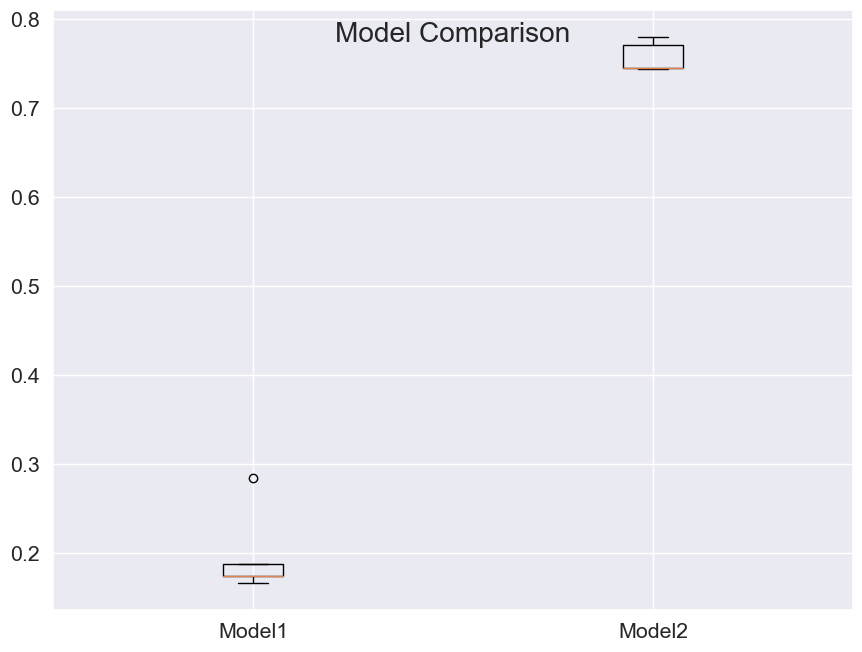

In [76]:
# Creating dataset
names = ["Model1", "Model2"]
data1_np = np.array(acc_results_model1)
data2_np = np.array(acc_results_model2)
data_all = [data1_np, data2_np]
fig = plt.figure(figsize =(8, 6))
fig.suptitle('Model Comparison') 
# Creating axes instance
ax = fig.add_axes([0,0,1,1])
# Creating plot
plt.boxplot(data_all)
ax.set_xticklabels(names)
 
# show plot
plt.show()

### 6.5) Interpretieren Sie die Ergebnisse. Welches der beiden Modelle ist besser?


Due to the non-deterministic nature of deep neuronal networks, accuracy scores vary from seed to seed. Hence, it's recommended to compare score distributions, rather than a single score. Comparing model1 and model2, the plot reveals that the quartiles of model2 are above those of model1. Further, we note a smaller standard deviation of model 2. Hence, we can conclude that model2 outperforms model1 due to it's higher score distribution and smaller standard deviation.

## 7.) Bauen Sie ein (einfaches) Ensemble  (20 Punkte)


### 7.1 Implementieren Sie ein einfaches majority-voting Ensemble (Empfehlung nehmen Sie die Modelle aus 6)

### 7.2) Evaluieren Sie den Ensemble-Klassifikator auf dem Test-set

### 7.3 Wie ist die Performanz des Ensembles im Vergleich zu den einzelnen Modellen? Welches Modell würden Sie am Ende einsetzen? Begründen Sie Ihre Antwort.

## 8.) Bitte schätzen Sie den benötigten Zeitaufwand für die Übung (optional)

Für die Übungen habe ich **XY Stunden** benötigt. Gerne auch detailliertere Abschätzungen  (pro Übung). 